Source of Elia Data Grid Load: https://www.elia.be/en/grid-data

# Installing relevant packages

In [ ]:
!pip install pmdarima
!pip install gdown
!gdown --id 161M2ar6K4ESB86D-qQCLsx0L87KFdrHl

# Libraries

In [ ]:
import pandas as pd # Data reading and wrangling
import matplotlib.pyplot as plt #Graphing
from datetime import datetime, timedelta, date #Time data managing
import numpy as np
import os
from gc import collect

from fbprophet import Prophet #Facebook's prophet for lineal predictions
from pmdarima import auto_arima #Auto arima for validation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Autocorrelation and partial autocorrelation plots for feature engineering
import holidays #Holidays package for feature engineering

from sklearn.preprocessing import MinMaxScaler #Scaling data for RNN and BPNN
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error # Loss functions and Metrics for model eval
from sklearn.metrics import median_absolute_error

import tensorflow as tf #DL module
from tensorflow.keras.models import Sequential # Building sequential models
from tensorflow.keras.layers import Dense # Output layers
from tensorflow.keras.layers import LSTM # RNN

from math import exp, sqrt
from random import seed
from random import random
from random import randrange
import time


import IPython
import IPython.display
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Reading Files and cleaning data

In [ ]:
"""
Data reading and prepping:
In this section we read the data consumption from Elia Grid Load (Source at the beggining)
We eliminate duplicate values
Inverse the data so it has a time coherent order
Reset index after inverting
Managing data types, in partiuclar we had datetime with timezone
Cutting data to only extract a relevant time window and cut computation time
Reindex data to hourly it was originally every 15 min, and we ran into computation time problems
Returns: Data is now cleaned, with correct format and ready to be used
"""
data = pd.read_csv("ods003.csv", sep=";")
data.drop_duplicates(subset = ['Datetime'], inplace=True)
data = data.iloc[::-1].copy() # Data inverting (new data lst)
data.reset_index(inplace=True, drop=True)
data['Datetime']= pd.to_datetime(data['Datetime'], utc=True) # Data converting to type datetime
data['Datetime'] = data['Datetime'].dt.tz_localize(None) # Eliminating timezone to work wiith UTC+0
f = data['Datetime'].iloc[-1]
data.set_index('Datetime', inplace=True, drop=True)
data = data[['Elia Grid Load']] # Eliminating Resolution Code because its the same value for the whole dataset
date_index = pd.date_range('1/1/2019', f, freq='H') #Creating datetime index each hour in the same date period that we are going to slice
data = data.reindex(date_index) # Data reindexing to change granularity to each hour
data.head(3) #Printing first 3 rows of sliced data

,Elia Grid Load
2019-01-01 00:00:00,7843.09
2019-01-01 01:00:00,7389.85
2019-01-01 02:00:00,7042.67


In [ ]:
data['Elia Grid Load'].isna().sum() # last check to see if we still had NAN values

0

In [ ]:
"""
Data splitting based on date:
Here we split based on a defnined training size, we chose 63% specifically because
at around 63.4% was the cut between 2020 and 2021, and normally one should cut in the
year change to account for holidays and stational effects
The parameter defined here as training_size is used all across the notebook
Returns: Data after cleaning is now split between train and test, no shuffle can be done
because of time series (Time dependent)
"""
training_size = int(len(data)*0.63) # number of registers that represent 63% of data
data.reset_index(inplace=True, drop=False) # Resetting index
data.rename(columns={'index':'ds'}, inplace=True) # renaming index to ds (ds because of prophet)
training_data = data.iloc[:training_size,:] # splitting training as first 63% of data
testing_data = data.iloc[training_size:,:] # splitting testing as last 27% od data
training_data.head(3) # Printing first 3 rows of data

,ds,Elia Grid Load
0,2019-01-01 00:00:00,7843.09
1,2019-01-01 01:00:00,7389.85
2,2019-01-01 02:00:00,7042.67


# Prophet - Linear Model

In [ ]:
training_data = training_data.rename(columns={ 'Elia Grid Load':'y'}) #Renaming Prophet only reads columns DS and Y
testing_data = testing_data.rename(columns={'Elia Grid Load':'y'}) # Renaming test
training_data.head(3)

,ds,y
0,2019-01-01 00:00:00,7843.09
1,2019-01-01 01:00:00,7389.85
2,2019-01-01 02:00:00,7042.67


In [ ]:
tau = [0.5, 0.1, 0.01, 0.05, 0.06] #Hyperparameters evaluation 
eval ={} # dict to evaluate results of each parameter
for t in tau: # for loop to evaluate each posible parameter
  m = Prophet(changepoint_prior_scale=t) #Declaring model with defined parameters 
  m.add_country_holidays(country_name='BE') # Adding holidays from inside the same prophet model
  m.fit(training_data) # fitting model to train data
  future = m.make_future_dataframe(periods=len(testing_data), freq='H') # Creating empty dataframe with empty rows the same length as testing data
  fcst = m.predict(future) # predicting
  fcst['y_true'] = data['Elia Grid Load'] # adding to the prediction dataframe, the real value
  eval[t] = mean_absolute_percentage_error(fcst['y_true'].values[training_size:], fcst['yhat'].values[training_size:]) # mape between test data and predicted data
  # Saving data 

m = Prophet(changepoint_prior_scale=min(eval, key=eval.get)) # Here the tau that got the minimum mape is selected 
#m = Prophet() # Here the tau that got the minimum mape is selected 
# rrest of the model is the same es the evaluation phase
m.add_country_holidays(country_name='BE')
m.fit(training_data)
future = m.make_future_dataframe(periods=len(testing_data), freq='H')
fcst = m.predict(future)
fcst['y_true'] = data['Elia Grid Load']
print('Best changepoint parameter was', t)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Best changepoint parameter was 0.06


In [ ]:
"""
Auto arima for validation:
Normally in regression one should compare every model to a baseline
To see if the model actually improves over a simplistic base model
In time series, normally ARIMA is used as base_line to check against other models
here auto arima from pmdarima was used.
"""
arima_auto_model = auto_arima(training_data.y, trace=True, error_action="ignore", suppress_warnings=True)
arima_auto_model.fit(training_data.y)

forecast = arima_auto_model.predict(n_periods=len(testing_data))
testing_data["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=242742.571, Time=25.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=256019.288, Time=0.55 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=246411.410, Time=1.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=247884.729, Time=7.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=256017.289, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=245105.267, Time=15.74 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=242759.335, Time=16.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=46.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=242738.975, Time=35.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=28.98 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=242733.293, Time=49.59 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=78.09 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=242720.251, Time=57.23 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=242719.022, Time=53.33 sec
 ARIMA(1,1,4)(0,

In [ ]:
full_auto_arima_predict = np.concatenate((arima_auto_model.predict_in_sample(), forecast))

In [ ]:
fcst["Forecast_ARIMAX"] = full_auto_arima_predict

In [ ]:
# Prophet
y_predicted_prophet = fcst.iloc[training_size:]['yhat'].values
y_test = fcst.iloc[training_size:]['y_true'].values
print("{:.4f} - Prophet MAPE".format(mean_absolute_percentage_error(y_test, y_predicted_prophet)))
print("{:.2f} - Prophet MAE".format(mean_absolute_error(y_test, y_predicted_prophet)))
print("{:.2f} - Prophet MSE ".format(mean_squared_error(y_test, y_predicted_prophet)))
print("{:.2f} - Prophet MeAE ".format(median_absolute_error(y_test, y_predicted_prophet)))

0.4784 - Prophet MAPE
3639.89 - Prophet MAE
16356935.08 - Prophet MSE 
3934.57 - Prophet MeAE 


In [ ]:
# Auto Univariate Sarimax
y_predicted_arima = fcst.iloc[training_size:]['Forecast_ARIMAX'].values
y_test = fcst.iloc[training_size:]['y_true'].values
print("{:.4f} - Auto-Arima MAPE".format(mean_absolute_percentage_error(y_test, y_predicted_arima)))
print("{:.2f} - Auto-Arima MAE".format(mean_absolute_error(y_test, y_predicted_arima)))
print("{:.2f} - Auto-Arima MSE".format(mean_squared_error(y_test, y_predicted_arima)))
print("{:.2f} - Auto-Arima MeAE".format(median_absolute_error(y_test, y_predicted_arima)))

0.1441 - Auto-Arima MAPE
1200.68 - Auto-Arima MAE
2293601.99 - Auto-Arima MSE
1008.22 - Auto-Arima MeAE


Here we can see that auto arima performance was overly superior to prophet, demonstrating that not always complex models are better, and arima has parameter optimization built in with auto arima.

In [ ]:
fcst['residuals'] = fcst.apply(lambda x: (x.Forecast_ARIMAX - x.y_true), axis=1) #Simple residual calculation
fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Allerheiligen,Allerheiligen_lower,Allerheiligen_upper,Dag van de Arbeid,...,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y_true,Forecast_ARIMAX,residuals
0,2019-01-01 00:00:00,10120.911780,6660.723221,8451.442597,10120.911780,10120.911780,0.0,0.0,0.0,0.0,...,407.731678,407.731678,407.731678,0.0,0.0,0.0,7529.413822,7843.09,0.000000,-7843.090000
1,2019-01-01 01:00:00,10120.166564,6291.352038,8082.620118,10120.166564,10120.166564,0.0,0.0,0.0,0.0,...,411.189917,411.189917,411.189917,0.0,0.0,0.0,7210.247791,7389.85,8472.640584,1082.790584
2,2019-01-01 02:00:00,10119.421349,6215.184583,7979.137582,10119.421349,10119.421349,0.0,0.0,0.0,0.0,...,413.195108,413.195108,413.195108,0.0,0.0,0.0,7064.647910,7042.67,6927.668264,-115.001736
3,2019-01-01 03:00:00,10118.676133,6286.670825,8053.103236,10118.676133,10118.676133,0.0,0.0,0.0,0.0,...,413.904675,413.904675,413.904675,0.0,0.0,0.0,7204.095084,6798.36,6766.309171,-32.050829
4,2019-01-01 04:00:00,10117.930917,6693.971245,8456.571802,10117.930917,10117.930917,0.0,0.0,0.0,0.0,...,413.478026,413.478026,413.478026,0.0,0.0,0.0,7593.688733,6745.39,6674.903364,-70.486636


# Residual prepping

In [ ]:
residuals_df = fcst[['ds', 'residuals']]

In [ ]:
df = residuals_df.copy()
df = df.set_index('ds', drop=True)
df

,residuals
ds,
2019-01-01 00:00:00,-7843.090000
2019-01-01 01:00:00,1082.790584
2019-01-01 02:00:00,-115.001736
2019-01-01 03:00:00,-32.050829
2019-01-01 04:00:00,-70.486636
...,...
2022-02-26 06:00:00,-933.776745
2022-02-26 07:00:00,-860.419745
2022-02-26 08:00:00,-504.930745


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


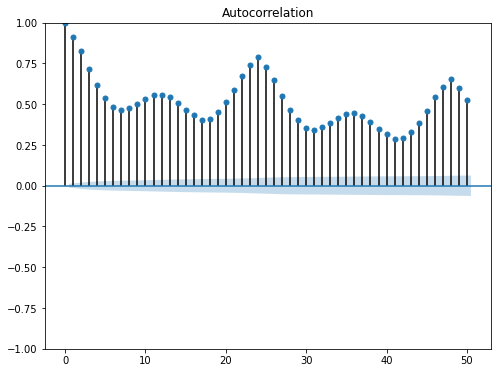

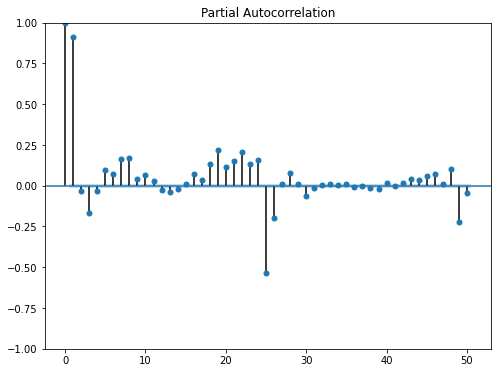

In [ ]:
plot_acf(df['residuals'], lags=50) #ACF to find relevant lags to use in feature engineering
plt.savefig('acf.eps', format='eps')
plot_pacf(df['residuals'], lags=50)
plt.savefig('pacf.eps', format='eps')
plt.show()


# Feature engineering for RNN

In [ ]:
def generate_time_lags(df, n_lags, col='residuals'):
    """
    generate_time_lags is a Function to obtaing the lags out of a dataframe and name the added columns
    in an efficient way
    :df: Univariate dataframe with the sequential data
    :n_lags: how many lags should be added as new columns
    Returns: df_n a Pandas Dataframe with as many new columns as lags were inputed
    """
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n[col].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n
    
input_dim = 24 #Number extracted from PACF above

df_generated = generate_time_lags(df, input_dim)

In [ ]:
df_features = (
                df
                .assign(hour = df.index.hour) # New column extracting the hour out of the date
                .assign(day = df.index.day) # New column extracting the day of the year out of the date
                .assign(month = df.index.month) # New column extracting the month out of the date
                .assign(day_of_week = df.index.dayofweek) # New column extracting the day of the week out of the date
                .assign(week_of_year = df.index.isocalendar().week) # New column extracting the week of the year out of the date
              )
def generate_cyclical_features(df, col_name, period, start_num=0):
  """
  generate_cyclical_features is a Function that converts date features into frequency features,
  when passing this kind of features (datetime) to a neural network, one should take into account that in the day of the week the after the 7
  comes 1, and it has no logical or mathematical sense, however when this features are tansformed into sine or cosine sequences they 
  conserve their sequential correlation
  :df: Dataframe with the date columns already extracted i.e. hour should be and int between (0, 23)
  :col_name: column name of the date feature to convert
  :period: Frequency of repetition i.e. day of year every 365, day of week every 7, hour of the day every 24
  :start_num: Default is 0, use when one wants to shift the start of the frequency
  """
  kwargs = {
      #f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
      f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
            }
  return df.assign(**kwargs).drop(columns=[col_name])

df_features = generate_cyclical_features(df_features, 'hour', 24, 0)
df_features = generate_cyclical_features(df_features, 'day', 365, 0)
df_features = generate_cyclical_features(df_features, 'day_of_week', 7, 0)
df_features = generate_cyclical_features(df_features, 'month', 12, 1)
df_features = generate_cyclical_features(df_features, 'week_of_year', 52, 0)


In [ ]:
belgian_holidays = holidays.BE()

def is_holiday(date):
    date = date.replace(hour = 0)
    return 1 if (date in belgian_holidays) else 0 # One hot encoding 1, when holiday, 0 when not holiday

def add_holiday_col(df, holidays):
    return df.assign(is_holiday = df.index.to_series().apply(is_holiday)) # creating the column


df_features = add_holiday_col(df_features, belgian_holidays)

In [ ]:
df_features = pd.merge(df_features, df_generated, left_index=True, right_index=True)
df_features['value'] = df_features['residuals_x']
df_features = df_features.iloc[24:,:].copy()
df_features = df_features.drop(columns=['residuals_y', 'residuals_x'])
df_features.drop(columns=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17', 'lag18', 'lag19',
                          'lag20', 'lag21', 'lag22', 'lag23'], inplace=True)
df_features.head(4)

,cos_hour,cos_day,cos_day_of_week,cos_month,cos_week_of_year,is_holiday,lag24,value
ds,,,,,,,,
2019-01-03 00:00:00,1.000000,0.998667,-0.900969,1.0,0.992709,0,56.180785,-82.740573
2019-01-03 01:00:00,0.965926,0.998667,-0.900969,1.0,0.992709,0,-39.103677,101.885636
2019-01-03 02:00:00,0.866025,0.998667,-0.900969,1.0,0.992709,0,48.673784,174.275106
2019-01-03 03:00:00,0.707107,0.998667,-0.900969,1.0,0.992709,0,13.769511,-183.575279


# RNN

## Univariate LSTM

In [ ]:
residuals_df = residuals_df.rename(columns={'ds':'Date'})
df1 = residuals_df.set_index('Date')
df1.head()

,residuals
Date,
2019-01-01 00:00:00,-7843.090000
2019-01-01 01:00:00,1082.790584
2019-01-01 02:00:00,-115.001736
2019-01-01 03:00:00,-32.050829
2019-01-01 04:00:00,-70.486636


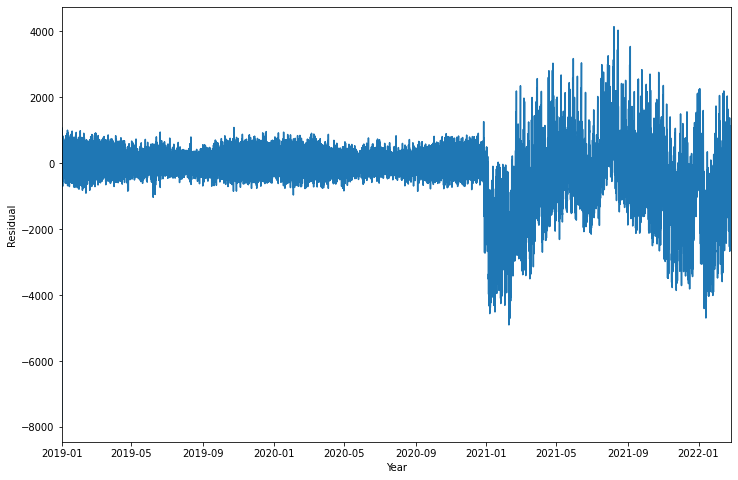

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.plot(df1.index, df1.residuals)
plt.xlim([min(df1.index), max(df1.index)])
plt.xlabel('Year')
plt.ylabel('Residual')
plt.show()

In [ ]:
# To be able to pass data to a Neural Network, data should be scaled, here we use MinMax
scaler = MinMaxScaler()
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1)) #Here data gets reshaped to avoid
# the shape of (n,) which leaves an unstructured array and thats the reason (-1, 1) is used.
print(type(df1)) # Printing type of the data (Before we had DF with time index, now as it is univariate we have an array of values)
df1[:5] #First 5 values

<class 'numpy.ndarray'>


array([[0.        ],
       [0.74480595],
       [0.64485807],
       [0.65177978],
       [0.64857256]])

In [ ]:
train_data  = df1[:training_size,:] # Indexing array to get train data
test_data = df1[training_size:,:1] # test data after splitting

In [ ]:
def create_dataset(dataset, timestep=1):
    dataX, dataY = [], []
    for i in range (len(dataset)-timestep-1):
        a = dataset[i:(i+timestep), 0]
        dataX.append(a)
        dataY.append(dataset[i + timestep, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
timestep = 24 #Setting different timestep than default, this feature could be extracted from ACF and PACF
X_train, Y_train = create_dataset(train_data, timestep) # Creating training dataset with aux function
X_test, ytest = create_dataset(test_data, timestep) # creating testing dataset with aux function

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) #Above we can see the error of (n,) in the shape of the arrays
#here we reshape including the number of features used, in this case 10 timesteps of lagging data. In other words, 10 periods behind.
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# building the model
#The use of return sequences true is to activate the use of results of each layer as inputs for the next layer

uni_model = Sequential()
uni_model.add(LSTM(50, return_sequences = True, input_shape=(timestep,1))) #only first layer needs input shape
uni_model.add(LSTM(50, return_sequences = True)) 
uni_model.add(LSTM(50))
uni_model.add(Dense(1))
# other losses are rmse, mae, mape, smape, etc
# adam is the most common optimizer

In [ ]:
uni_model.summary() #summary of each layer

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 24, 50)            10400     
                                                                 
 lstm_10 (LSTM)              (None, 24, 50)            20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
MAX_EPOCHS = 20 # Low number of epochs for simpler model
patience = int(0.1*MAX_EPOCHS) #patience so the model stops after this number of models where the monitor value does not minimize (Or maximizes depending on mode)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # Early stopping to check if model reaches an optimum before the total number of epochs
                                                    patience=patience,
                                                    mode='min')

uni_model.compile(loss=tf.losses.MeanSquaredError(), # model compiler, loss functino used is MSE
                optimizer=tf.optimizers.Adam(), # Adam optimizer
                metrics=[tf.metrics.MeanAbsoluteError()]) # metric is MAE

uni_model.fit(X_train, Y_train,  # Fitting the model
          epochs=MAX_EPOCHS,
          validation_data=(X_test, ytest), # validation data, to extract val_loss
          callbacks=[early_stopping],
          batch_size = 24, #batch size due to PACF indicator of lags
          verbose = 1) # Display results

Epoch 1/20
725/725 [==============================] - 31s 35ms/step - loss: 0.0025 - mean_absolute_error: 0.0233 - val_loss: 0.0091 - val_mean_absolute_error: 0.0786
Epoch 2/20
725/725 [==============================] - 23s 32ms/step - loss: 5.2424e-04 - mean_absolute_error: 0.0177 - val_loss: 0.0092 - val_mean_absolute_error: 0.0786
Epoch 3/20
725/725 [==============================] - 24s 34ms/step - loss: 5.2002e-04 - mean_absolute_error: 0.0176 - val_loss: 0.0102 - val_mean_absolute_error: 0.0819


In [ ]:
train_predict = uni_model.predict(X_train) # In-sample prediction
test_predict = uni_model.predict(X_test)#Out of sample prediction

In [ ]:
train_predict = scaler.inverse_transform(train_predict) # Inverse scaling
test_predict = scaler.inverse_transform(test_predict) #Inverse scaling

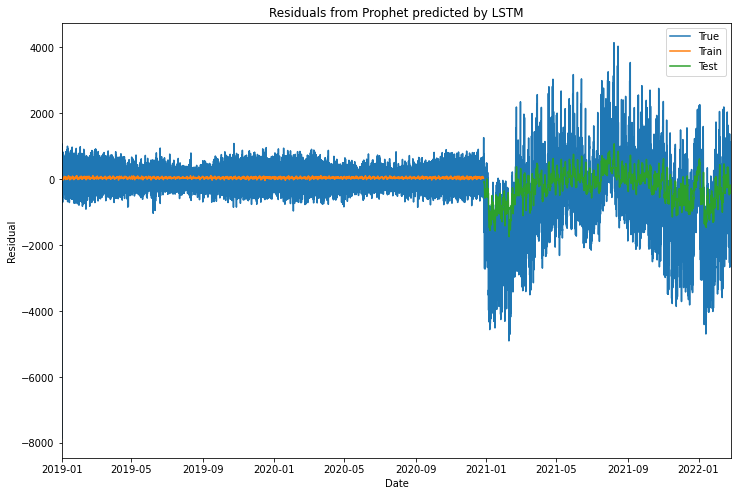

In [ ]:
# Plotting
# Shifting train predictions for plotting

look_back = timestep
trainPredictPlot_uni = np.empty_like(df1)
trainPredictPlot_uni[:,:] =np.nan
trainPredictPlot_uni[look_back: len(train_predict)+ look_back,:]= train_predict
# shift test prediction for plotting
testPredictPlot_uni = np.empty_like(df1)
testPredictPlot_uni[:,:]= np.nan
testPredictPlot_uni[len(train_predict)+ (look_back*2)+1:len(df1)-1, :]= test_predict
#plot baseline and predictions
plt.rcParams["figure.figsize"] = (12, 8)
plt.xlim([min(df.index), max(df.index)])
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residuals from Arima predicted by LSTM')
plt.plot(df.index, scaler.inverse_transform(df1))
plt.plot(df.index, trainPredictPlot_uni)
plt.plot(df.index, testPredictPlot_uni)
plt.legend(['True', 'Train', 'Test'])
plt.show()

## Multivariate LSTM

In [ ]:
df_features = df_features[['value', 'cos_hour', 'cos_day', 'cos_day_of_week', 'cos_month',
       'cos_week_of_year', 'is_holiday', 'lag24']] # organizing variable so that response variable is first

In [ ]:
scaler_lstm = MinMaxScaler()
scaled = scaler_lstm.fit_transform(df_features.values) # scaling
def to_supervised(data,dropNa = True,lag = 1): # function to construct a supervised dataframe based on sequences
    df = pd.DataFrame(data) # this is to show the RNN the past values for each feature
    column = [] # so the df at the end gets the shape (number of rows, timesteps, features)
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = data.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    return supervised_data


supervised = to_supervised(scaled, lag=timestep)

features = df_features.shape[1] # extracting features
X = supervised[:,:features*timestep] # getting the "independet variables" this is all the sequences of timesteps of all of the features for the response variable in that exact period
y = supervised[:,features*timestep] # extracting value of "dependent variable" the original scaled value

x_train = X[:training_size,:]
x_test = X[training_size:,:]
y_train = y[:training_size]
y_test = y[training_size:]

x_train = x_train.reshape(x_train.shape[0], timestep, features) # reshaping as tensors to work as input to keras model
x_test = x_test.reshape(x_test.shape[0], timestep, features) # reshaping as tensor


multi_model = Sequential() # defining sequential model
multi_model.add(LSTM(features*timestep, return_sequences = True, input_shape=(timestep, x_train.shape[2]))) # adding input lstm layer, input shape is timestep, features, only defining input shape once
multi_model.add(LSTM(features*timestep, return_sequences = True)) #one more lstm layer, batch size is timestep*features, input layer and second layer have return sequences true, so they use their result as input
multi_model.add(LSTM(features*timestep)) # last lstm layer, to compact results from past layer
multi_model.add(Dense(1)) # dense layer to output information

MAX_EPOCHS = 30 

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

multi_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

multi_model.fit(x_train, y_train, 
          epochs=MAX_EPOCHS,
          validation_data=(x_test, y_test),
          callbacks=[early_stopping],
          batch_size = features*timestep, 
          verbose = 1)


Epoch 1/30
91/91 [==============================] - 80s 812ms/step - loss: 0.0051 - mean_absolute_error: 0.0391 - val_loss: 0.0168 - val_mean_absolute_error: 0.1054
Epoch 2/30
91/91 [==============================] - 58s 637ms/step - loss: 8.5485e-04 - mean_absolute_error: 0.0220 - val_loss: 0.0164 - val_mean_absolute_error: 0.1045
Epoch 3/30
91/91 [==============================] - 58s 644ms/step - loss: 8.6570e-04 - mean_absolute_error: 0.0222 - val_loss: 0.0163 - val_mean_absolute_error: 0.1044
Epoch 4/30
91/91 [==============================] - 56s 621ms/step - loss: 8.4097e-04 - mean_absolute_error: 0.0218 - val_loss: 0.0162 - val_mean_absolute_error: 0.1039
Epoch 5/30
91/91 [==============================] - 58s 634ms/step - loss: 8.4966e-04 - mean_absolute_error: 0.0220 - val_loss: 0.0158 - val_mean_absolute_error: 0.1031
Epoch 6/30
91/91 [==============================] - 57s 627ms/step - loss: 8.8083e-04 - mean_absolute_error: 0.0225 - val_loss: 0.0160 - val_mean_absolute_erro

In [ ]:
#scale back the prediction to orginal scale
y_pred = multi_model.predict(x_test) # prediction

x_test = x_test.reshape(x_test.shape[0],x_test.shape[2]*x_test.shape[1]) #Reshaping df from tensor to original timestep*features lagging
y_test = y_test.reshape( len(y_test), 1) # reshape to avoid (n,) shape that outputs errors sometimes due to shape not coinciding


y_train = multi_model.predict(x_train) # in sample prediction for validation and plotting
x_train = x_train.reshape(x_train.shape[0],x_train.shape[2]*x_train.shape[1]) # reshaping from tensor
inv_new = np.concatenate( (y_train, x_train[:,-(features-1):]) , axis =1) # concatenating original features with predicted value
inv_new = scaler_lstm.inverse_transform(inv_new) #inverse scaling
multi_model_train_pred = inv_new[:,-1:] # extracting only prediction

In [ ]:
inv_new = np.concatenate( (y_pred, x_test[:,-(features-1):]) ,axis = 1) # explained above, concatenating predicted value with original features to descale
inv_new = scaler_lstm.inverse_transform(inv_new)
multi_model_pred = inv_new[:,-1:]

In [ ]:
multi_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 24, 192)           154368    
                                                                 
 lstm_13 (LSTM)              (None, 24, 192)           295680    
                                                                 
 lstm_14 (LSTM)              (None, 192)               295680    
                                                                 
 dense_7 (Dense)             (None, 1)                 193       
                                                                 
Total params: 745,921
Trainable params: 745,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
size_left =  len(np.concatenate((multi_model_train_pred, multi_model_pred)))
size_actual = len(data)
filler = np.zeros((size_actual - size_left)).reshape(-1, 1)
full_predicted_residuals = np.concatenate((filler, multi_model_train_pred, multi_model_pred))

In [ ]:
full_uni_predicted_values = np.concatenate((np.nan_to_num(trainPredictPlot_uni[:training_size]), np.nan_to_num(testPredictPlot_uni[training_size:])))

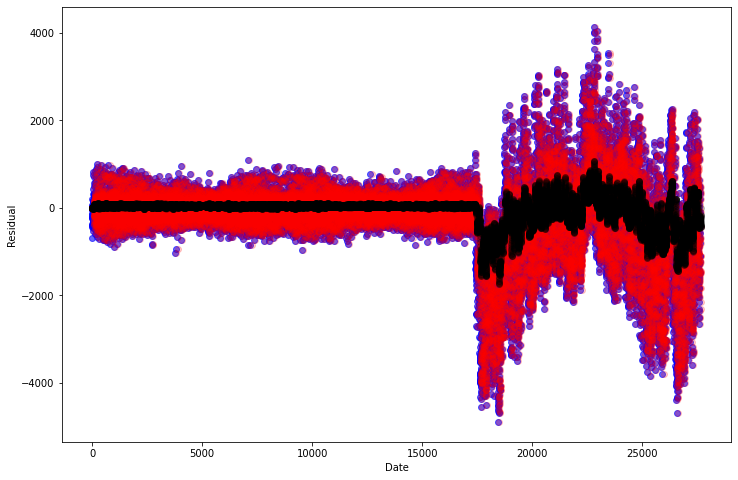

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.plot(df_features.values[:,-1:], 'bo', alpha=0.6)
plt.plot(full_predicted_residuals,'ro', alpha=0.2)
plt.plot(full_uni_predicted_values,'ko', alpha=0.2)
plt.show()

This behaviour is expected, residuals from in sample are constant white noise around 0, however residuals increase when out of sample prediciton is made, later in the notebook we explain how we treat these differences.

In [ ]:
y_uni_lstm = np.nan_to_num(testPredictPlot_uni)[training_size:]
y_test = fcst.iloc[training_size:]['residuals'].values.reshape(-1,1)
y_multi_lstm = full_predicted_residuals[training_size:]


In [ ]:
# Multi LSTM
print("{:.4f} - Multi LSTM MAPE".format(mean_absolute_percentage_error(y_test, y_multi_lstm)))
print("{:.2f} - Multi LSTM MAE".format(mean_absolute_error(y_test, y_multi_lstm)))
print("{:.2f} - Multi LSTM MSE ".format(mean_squared_error(y_test, y_multi_lstm)))
print("{:.2f} - Multi LSTM MeAE ".format(median_absolute_error(y_test, y_multi_lstm)))

3.2209 - Multi LSTM MAPE
762.22 - Multi LSTM MAE
1016760.89 - Multi LSTM MSE 
585.61 - Multi LSTM MeAE 


In [ ]:
# UniLSTM
print("{:.4f} - Uni LSTM MAPE".format(mean_absolute_percentage_error(y_test, y_uni_lstm)))
print("{:.2f} - Uni LSTM MAE".format(mean_absolute_error(y_test, y_uni_lstm)))
print("{:.2f} - Uni LSTM MSE ".format(mean_squared_error(y_test, y_uni_lstm)))
print("{:.2f} - Uni LSTM MeAE ".format(median_absolute_error(y_test, y_uni_lstm)))

1.7366 - Uni LSTM MAPE
980.30 - Uni LSTM MAE
1462179.34 - Uni LSTM MSE 
845.57 - Uni LSTM MeAE 


Even though there is a clear difference between the multivariate prediction and univariate prediction for LSTM in MAPE, specifically for the residuals. In all the other metrics, the multivariate model seems to be more robust and that it explains better the data, probably because of holidays and time features. So the values predicted from multivariate LSTM are used in the latter steps. and also for validation purposes.

## Multivariate LSTM for Validation with real data (for latter comparison)

In [ ]:
# Validation of the model using real data (Not residuals) to compare
"""
This section uses the multivariate LSTM model to predict the whole dataset, not only the residuals, to be able to compare the performance
of this model vs the hybrid model vs the linear model and also as validation

This code is used for the multivariate prediction of residuals before so documentation and commenting is less accurate as
the procedure was already explained. Refer to previous code or to the paper.

Inputs: Original dataframe name data
Returns: Prediction of the electrical load
"""
df_original = data.copy()
df_original = df_original.set_index('ds', drop=True)
df_lag_original = generate_time_lags(df_original, 24, col='Elia Grid Load')

df_original_features = (
                df_original
                .assign(hour = df_original.index.hour) 
                .assign(day = df_original.index.day) 
                .assign(month = df_original.index.month) 
                .assign(day_of_week = df_original.index.dayofweek) 
                .assign(week_of_year = df_original.index.isocalendar().week)
              )
  
df_original_features = generate_cyclical_features(df_original_features, 'hour', 24, 0)
df_original_features = generate_cyclical_features(df_original_features, 'day', 365, 0)
df_original_features = generate_cyclical_features(df_original_features, 'day_of_week', 7, 0)
df_original_features = generate_cyclical_features(df_original_features, 'month', 12, 1)
df_original_features = generate_cyclical_features(df_original_features, 'week_of_year', 52, 0)

df_original_features = add_holiday_col(df_original_features, belgian_holidays)

df_original_features['lag24'] = df_lag_original['lag24']
df_original_features = df_original_features.dropna()

df_original_features['value'] = df_original_features['Elia Grid Load']
df_original_features = df_original_features.drop(columns=['Elia Grid Load'])

df_original_features = df_original_features[['value', 'cos_hour', 'cos_day', 'cos_day_of_week', 'cos_month',
       'cos_week_of_year', 'is_holiday', 'lag24']]


scaler_original_multi_lstm = MinMaxScaler()
original_scaled = scaler_original_multi_lstm.fit_transform(df_original_features.values)

original_supervised = to_supervised(original_scaled, lag=timestep)

features = df_original_features.shape[1]

X = original_supervised[:,:features*timestep]
y = original_supervised[:,features*timestep]

x_train = X[:training_size,:]
x_test = X[training_size:,:]
y_train = y[:training_size]
y_test = y[training_size:]

x_train = x_train.reshape(x_train.shape[0], timestep, features)
x_test = x_test.reshape(x_test.shape[0], timestep, features)


original_multi_model = Sequential()
original_multi_model.add(LSTM(features*timestep, return_sequences = True, input_shape=(timestep, x_train.shape[2])))
original_multi_model.add(LSTM(features*timestep, return_sequences = True)) 
original_multi_model.add(LSTM(features*timestep))
original_multi_model.add(Dense(1))

MAX_EPOCHS = 30

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

original_multi_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

original_multi_model.fit(x_train, y_train, 
          epochs=MAX_EPOCHS,
          validation_data=(x_test, y_test),
          callbacks=[early_stopping],
          batch_size = features*timestep, 
          verbose = 1)

y_pred = original_multi_model.predict(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2]*x_test.shape[1])

inv_new = np.concatenate( (y_pred, x_test[:,-(features-1):]) , axis =1)
inv_new = scaler_original_multi_lstm.inverse_transform(inv_new)
original_final_pred = inv_new[:,-1:]

Epoch 1/30
91/91 [==============================] - 84s 861ms/step - loss: 0.0151 - mean_absolute_error: 0.0920 - val_loss: 0.0101 - val_mean_absolute_error: 0.0796
Epoch 2/30
91/91 [==============================] - 56s 617ms/step - loss: 0.0071 - mean_absolute_error: 0.0667 - val_loss: 0.0086 - val_mean_absolute_error: 0.0730
Epoch 3/30
91/91 [==============================] - 57s 633ms/step - loss: 0.0042 - mean_absolute_error: 0.0500 - val_loss: 0.0055 - val_mean_absolute_error: 0.0570
Epoch 4/30
91/91 [==============================] - 58s 638ms/step - loss: 0.0029 - mean_absolute_error: 0.0419 - val_loss: 0.0052 - val_mean_absolute_error: 0.0574
Epoch 5/30
91/91 [==============================] - 56s 615ms/step - loss: 0.0026 - mean_absolute_error: 0.0396 - val_loss: 0.0047 - val_mean_absolute_error: 0.0527
Epoch 6/30
91/91 [==============================] - 57s 623ms/step - loss: 0.0021 - mean_absolute_error: 0.0358 - val_loss: 0.0025 - val_mean_absolute_error: 0.0392
Epoch 7/30

In [ ]:
y_train_predicted = original_multi_model.predict(x_train)
x_train = x_train.reshape(x_train.shape[0],x_train.shape[2]*x_train.shape[1])

inv_new = np.concatenate( (x_train[:,-(features-1):] , y_train_predicted) , axis =1)
inv_new = scaler_original_multi_lstm.inverse_transform(inv_new)
original_train_pred = inv_new[:,-1:]

In [ ]:
size_left =  len(np.concatenate((original_train_pred, original_final_pred)))
size_actual = len(data)
filler = np.zeros((size_actual - size_left)).reshape(-1, 1)
original_full_predicted_data = np.concatenate((filler, original_train_pred, original_final_pred))

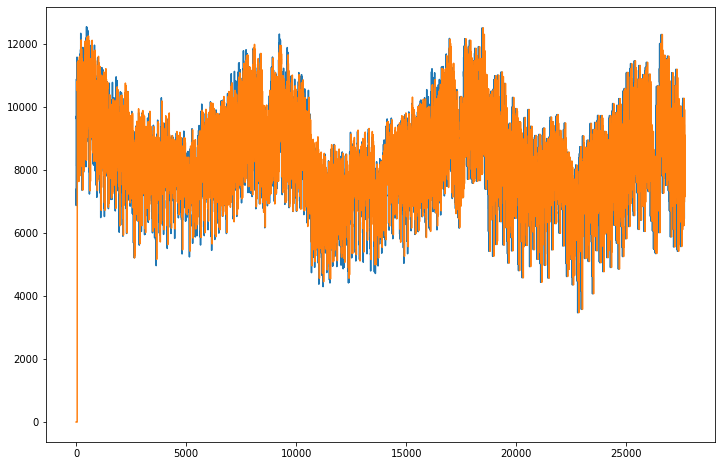

In [ ]:
plt.plot(df_original_features['value'].values)
plt.plot(original_full_predicted_data)
plt.show()

# BPNN

In [ ]:
linear_train_preds = fcst.iloc[:training_size,:]['yhat'].values.reshape(-1,1)
linear_test_preds = fcst.iloc[training_size:,:]['yhat'].values.reshape(-1,1)

In [ ]:
nonlinear_train_preds = full_predicted_residuals[:training_size]
nonlinear_test_preds = full_predicted_residuals[training_size:]

In [ ]:
sum_train_fcst = np.add(linear_train_preds, nonlinear_train_preds)
sum_test_fcst = np.add(linear_test_preds, nonlinear_test_preds)
sum_fcst = np.concatenate((sum_train_fcst, sum_test_fcst))

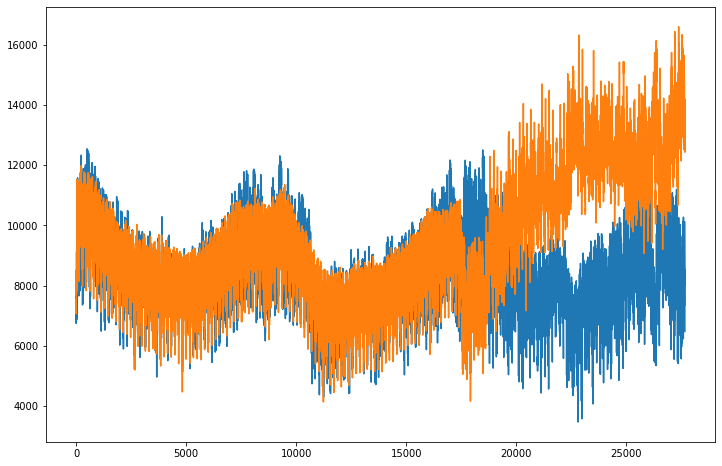

In [ ]:
plt.plot(fcst['y_true'].values)
plt.plot(sum_fcst)
plt.show() #Here we can realize that the residuals from the out of sample prediction would not be appropiate for testing, so we concatenate 
# the normal values with the sum of forecast 

In [ ]:
sum_fcst_corrected = np.concatenate((sum_fcst[:training_size], fcst['y_true'].values[training_size:].reshape(-1,1)))

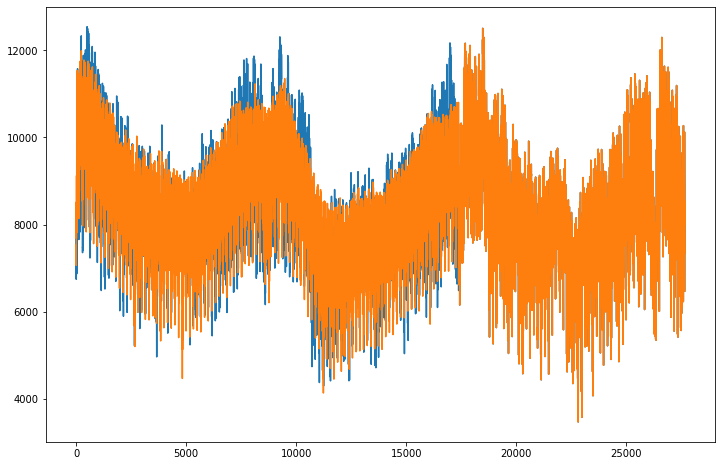

In [ ]:
plt.plot(fcst['y_true'].values)
plt.plot(sum_fcst_corrected)
plt.show() 

In [ ]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(sum_fcst_corrected)
timestep = 24 
X_train, Y_train = create_dataset(df_scaled[:training_size], timestep) 
X_test, Y_test = create_dataset(df_scaled[training_size:], timestep) 

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) #Above we can see the error of (n,) in the shape of the arrays
#here we reshape including the number of features used, in this case 10 timesteps of lagging data. In other words, 10 periods behind.
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
MAX_EPOCHS=100
# Initialising the ANN
Reggresor = Sequential()


# Adding the input layer  
Reggresor.add(Dense(24,  kernel_initializer='normal', activation = 'relu', input_dim = X_train.shape[1]))

# Adding the first hidden layer with 24 nodes
Reggresor.add(Dense(24, kernel_initializer='normal', activation = 'relu'))

# Adding the output layer with one output of energy load prediction
Reggresor.add(Dense(1, kernel_initializer='normal', activation='linear'))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

Reggresor.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])


Reggresor.fit(X_train, Y_train, 
          epochs=MAX_EPOCHS,
          validation_data=(X_test, Y_test),
          callbacks=[early_stopping],
          batch_size = 24, 
          verbose = 1)

Epoch 1/100
725/725 [==============================] - 2s 3ms/step - loss: 0.0144 - mean_absolute_error: 0.0675 - val_loss: 0.0040 - val_mean_absolute_error: 0.0502
Epoch 2/100
725/725 [==============================] - 2s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0326 - val_loss: 0.0033 - val_mean_absolute_error: 0.0453
Epoch 3/100
725/725 [==============================] - 2s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0316 - val_loss: 0.0030 - val_mean_absolute_error: 0.0434
Epoch 4/100
725/725 [==============================] - 2s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0312 - val_loss: 0.0028 - val_mean_absolute_error: 0.0414
Epoch 5/100
725/725 [==============================] - 2s 2ms/step - loss: 0.0015 - mean_absolute_error: 0.0309 - val_loss: 0.0026 - val_mean_absolute_error: 0.0406
Epoch 6/100
725/725 [==============================] - 2s 2ms/step - loss: 0.0015 - mean_absolute_error: 0.0306 - val_loss: 0.0025 - val_mean_absolute_error: 0.0396
Epoch 7/10

In [ ]:
Reggresor.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 24)                600       
                                                                 
 dense_10 (Dense)            (None, 24)                600       
                                                                 
 dense_11 (Dense)            (None, 1)                 25        
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_predict = Reggresor.predict(X_train)
test_predict = Reggresor.predict(X_test)

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

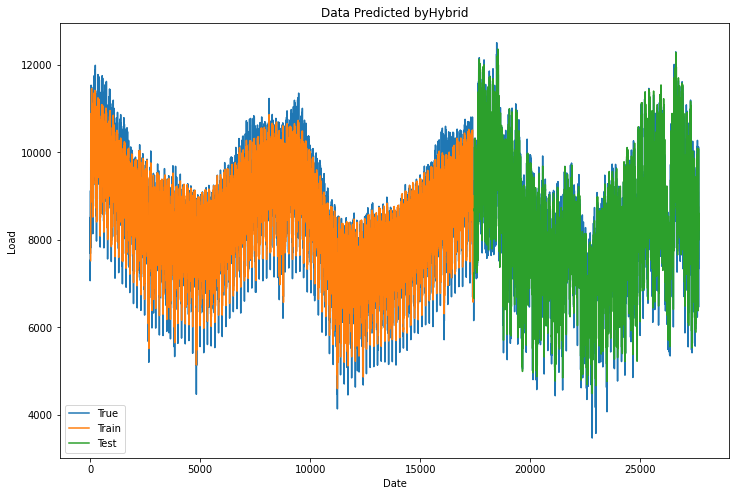

In [ ]:
# Plotting
# Shifting train predictions for plotting
ind = np.linspace(0, len(df_scaled), len(df_scaled))

look_back = timestep
trainPredictPlot = np.empty_like(df_scaled)
trainPredictPlot[:,:] =np.nan
trainPredictPlot[look_back: len(train_predict)+ look_back,:]= train_predict
# shift test prediction for plotting
testPredictPlot = np.empty_like(df_scaled)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(train_predict)+ (look_back*2)+1:len(df_scaled)-1, :]= test_predict
#plot baseline and predictions
plt.rcParams["figure.figsize"] = (12, 8)
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('Data Predicted byHybrid')
plt.plot(scaler.inverse_transform(df_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['True', 'Train', 'Test'])
plt.show()

# Comparison of all models

In [ ]:
# Auto Univariate Sarimax
y_predicted_arima = testing_data.Forecast_ARIMAX.values
y_test = testing_data.y.values
print("{:.4f} - Auto-Arima MAPE".format(mean_absolute_percentage_error(y_test, y_predicted_arima)))
print("{:.2f} - Auto-Arima MAE".format(mean_absolute_error(y_test, y_predicted_arima)))
print("{:.2f} - Auto-Arima MSE".format(mean_squared_error(y_test, y_predicted_arima)))
print("{:.2f} - Auto-Arima MeAE".format(median_absolute_error(y_test, y_predicted_arima)))

0.1441 - Auto-Arima MAPE
1200.68 - Auto-Arima MAE
2293601.99 - Auto-Arima MSE
1008.22 - Auto-Arima MeAE


In [ ]:
# Prophet
y_predicted_prophet = fcst.iloc[training_size:]['yhat'].values
y_test = fcst.iloc[training_size:]['y_true'].values
print("{:.4f} - Prophet MAPE".format(mean_absolute_percentage_error(y_test, y_predicted_prophet)))
print("{:.2f} - Prophet MAE".format(mean_absolute_error(y_test, y_predicted_prophet)))
print("{:.2f} - Prophet MSE ".format(mean_squared_error(y_test, y_predicted_prophet)))
print("{:.2f} - Prophet MeAE ".format(median_absolute_error(y_test, y_predicted_prophet)))

0.4784 - Prophet MAPE
3639.89 - Prophet MAE
16356935.08 - Prophet MSE 
3934.57 - Prophet MeAE 


In [ ]:
# Hybrid
y_predicted_hybrid = np.nan_to_num(testPredictPlot)[training_size:]
print("{:.4f} - Hybrid MAPE".format(mean_absolute_percentage_error(y_test, y_predicted_hybrid)))
print("{:.2f} - Hybrid MAE".format(mean_absolute_error(y_test, y_predicted_hybrid)))
print("{:.2f} - Hybrid MSE ".format(mean_squared_error(y_test, y_predicted_hybrid)))
print("{:.2f} - Hybrid MeAE ".format(median_absolute_error(y_test, y_predicted_hybrid)))

0.0448 - Hybrid MAPE
363.79 - Hybrid MAE
332969.49 - Hybrid MSE 
287.54 - Hybrid MeAE 


In [ ]:
# LSTM
y_predicted_multi_lstm = original_full_predicted_data[training_size:]
print("{:.4f} - Multi LSTM MAPE".format(mean_absolute_percentage_error(y_test, y_predicted_multi_lstm)))
print("{:.2f} - Multi LSTM MAE".format(mean_absolute_error(y_test, y_predicted_multi_lstm)))
print("{:.2f} - Multi LSTM MSE ".format(mean_squared_error(y_test, y_predicted_multi_lstm)))
print("{:.2f} - Multi LSTM MeAE ".format(median_absolute_error(y_test, y_predicted_multi_lstm)))

0.0961 - Multi LSTM MAPE
758.69 - Multi LSTM MAE
1011745.38 - Multi LSTM MSE 
579.99 - Multi LSTM MeAE 
